In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## 클래스 및 메소드 정의

In [ ]:
class Plane:
    def __init__(self, n: np.array, d: float):
        if not isinstance(n, np.ndarray):
            raise ValueError("n must be a numpy array")

        self.n = n
        self.d = d

    def distance(self, p: np.array):
        """Calculate the distance of a point to the plane"""
        return np.abs(np.dot(self.n, p) + self.d) / np.linalg.norm(self.n)

    def project_to_plane(self, p: np.array):
        """Project a 3D point onto the plane and return its 2D coordinates"""
        # Find a point on the plane
        point_on_plane = p - (np.dot(self.n, p) + self.d) * self.n

        # Create a local coordinate system on the plane
        u = np.array([-self.n[1], self.n[0], 0])  # Arbitrary vector orthogonal to n
        if np.allclose(u, 0):
            u = np.array([0, -self.n[2], self.n[1]])  # Handle edge case
        u = u / np.linalg.norm(u)  # Normalize
        v = np.cross(self.n, u)  # Ensure v is orthogonal to both n and u

        # Project the point onto the local 2D basis
        x = np.dot(point_on_plane, u)
        y = np.dot(point_on_plane, v)
        return np.array([x, y]), u, v

    def transform_covariance(self, cov_3d: np.array, u: np.array, v: np.array):
        """Transform a 3D covariance matrix to 2D on the plane"""
        # Transformation matrix from 3D to 2D
        T = np.stack((u, v), axis=0)  # Shape: (2, 3)
        # Project the covariance matrix
        cov_2d = T @ cov_3d @ T.T  # Shape: (2, 2)
        return cov_2d

    def transform_to_2d(self, position: np.array, covariance: np.array):
        """Transform a 3D position and covariance to 2D on the plane"""
        if not isinstance(position, np.ndarray) or not isinstance(
            covariance, np.ndarray
        ):
            raise ValueError("Position and covariance must be numpy arrays")
        if position.shape != (3,) or covariance.shape != (3, 3):
            raise ValueError(
                "Position must be a 3-element vector and covariance must be 3x3"
            )

        # Project position to 2D
        pos_2d, u, v = self.project_to_plane(position)

        # Transform covariance to 2D
        cov_2d = self.transform_covariance(covariance, u, v)

        return pos_2d, cov_2d

In [ ]:
# 인덱스 사이 구간을 가지는 데이터프레임으로 분할 (예외 처리 포함)
def split_dataframe_by_indices(df, indices):
    split_dataframes = []

    # 1. 첫 번째 구간: 처음부터 첫 번째 인덱스 이전까지
    if indices[0] > 0:
        split_dataframes.append(df.loc[: indices[0] - 1])

    # 2. 중간 구간: 각 인덱스 사이
    for start, end in zip(indices, indices[1:]):
        if start + 1 < end:  # 인덱스가 붙어 있지 않은 경우만 추가
            split_dataframes.append(df.loc[start + 1 : end - 1])

    # 3. 마지막 구간: 마지막 인덱스 이후부터 끝까지
    if indices[-1] < len(df) - 1:
        split_dataframes.append(df.loc[indices[-1] + 1 :])

    return split_dataframes

## 데이터 로드 및 병합. 기준 데이터: desired_box(10hz)

In [ ]:
root_dir = "/home/workspace/src/log_file/raw(1)"

pdf_file = "box_objects_pdf.csv"
control_mode_file = "control_mode.csv"
desired_box_file = "desired_box.csv"
distance_file = "intention_distance.csv"
intersection_length_file = "intention_intersection_length.csv"

pdf = pd.read_csv(os.path.join(root_dir, pdf_file)).drop(
    columns=["field.header.seq", "field.header.stamp", "field.header.frame_id"]
)
control_mode = pd.read_csv(os.path.join(root_dir, control_mode_file))
desired_box = pd.read_csv(os.path.join(root_dir, desired_box_file))
distance = pd.read_csv(os.path.join(root_dir, distance_file))
intersection_length = pd.read_csv(os.path.join(root_dir, intersection_length_file))


# 시간 데이터를 datetime 형식으로 변환
pdf["%time"] = pd.to_datetime(pdf["%time"])
control_mode["%time"] = pd.to_datetime(control_mode["%time"])
desired_box["%time"] = pd.to_datetime(desired_box["%time"])
distance["%time"] = pd.to_datetime(distance["%time"])
intersection_length["%time"] = pd.to_datetime(intersection_length["%time"])

# pdf 데이터의 시간을 기준으로 control_mode, desired_box, distance, intersection_length 데이터를 병합
data = pd.merge_asof(
    desired_box,
    control_mode,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)

data = pd.merge_asof(
    data,
    distance,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)

data = pd.merge_asof(
    data,
    intersection_length,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)

data = pd.merge_asof(
    data,
    pdf,
    on="%time",
    tolerance=pd.Timedelta("100ms"),
    direction="nearest",
)


display(data.head())
display(data.info())

data

## 데이터 후처리 및 Export

In [ ]:
# 주기에 맞지 않는 데이터 보간
data["control_mode"] = data["control_mode"].fillna(method="ffill")
data["desired_box"] = data["desired_box"].fillna(method="ffill")
data["eef_distance"] = data["eef_distance"].fillna(method="ffill")
data["intersection_length"] = data["intersection_length"].fillna(method="ffill")


data["control_mode"] = data["control_mode"].astype(int)
data["desired_box"] = data["desired_box"].astype(int)
data["eef_distance"] = data["eef_distance"].astype(float)
data["intersection_length"] = data["intersection_length"].astype(float)


data = data[
    data["desired_box"] != 200
]  # desired_box가 200인 데이터 제외. 200은 물체가 없음을 의미


tasks = {}

desired_box_values = data["desired_box"].unique().tolist()

# desired_box 값 별로 데이터프레임을 분할하여 tasks 딕셔너리에 저장
for desired_box in desired_box_values:
    tasks[str(desired_box)] = data[data["desired_box"] == desired_box]


# 각 task에 대해 pdf 데이터를 시각화
for key, task in tasks.items():
    task: pd.DataFrame

    # 타겟 박스 번호 추출, 딕셔너리 키
    target_id = int(key)

    # 시간 순으로 정렬
    task = task.sort_values(by="%time")

    """
        MANUAL = 0
        AUTO = 1
        FORCE_CONTROL = 2
        RESET = 8
        HOMING = 9
    """

    # control_mode 인덱스 추출 및 슬라이싱. 호밍 상태를 기준으로 슬라이싱
    indices = task.index[task["control_mode"] == 9].tolist()

    split_dataframes = split_dataframe_by_indices(task, indices)

    for i, splited_df in enumerate(split_dataframes):
        splited_df: pd.DataFrame

        # 데이터 전처리 : 무의미한 데이터 제거

        # 박스의 id, pdf 컬럼
        box_id_cols = [f"field.boxes{j}.id" for j in range(9)]
        box_pdf_cols = [f"field.boxes{k}.pdf" for k in range(9)]

        # 박스의 id, pdf 컬럼이 모두 NaN인 행 제거
        splited_df = splited_df.dropna(subset=box_id_cols)
        splited_df = splited_df.dropna(subset=box_pdf_cols)

        # control_mode가 0인 데이터만 추출
        splited_df = splited_df[splited_df["control_mode"] == 0]

        # intersection_length가 0보다 큰 데이터만 추출
        splited_df = splited_df[splited_df["intersection_length"] > 0]

        # 데이터 후처리 : 베이지안 필터링 적용

        # 새로운 컬럼 생성
        for csv_box_id in range(9):
            # 이전 인덱스 값과 현재 인덱스 값 계산
            prev_values = data[f"field.boxes{csv_box_id}.pdf"].shift(
                1, fill_value=(1.0 / 9.0)
            )  # 첫 번째 행의 이전 값은 1로 채움
            current_values = data[f"field.boxes{csv_box_id}.pdf"]

            possibility = prev_values  # 이전 확률
            not_prior = 1.0 - prev_values  # 이전 반대확률

            # 우도
            likelihood = current_values  # 우도
            not_likelihood = 1.0 - current_values  # 반대 우도

            # 사후확률 계산
            post_probability = likelihood * possibility  # 사후확률
            post_not_probability = not_likelihood * not_prior  # 반대 사후확률

            # 정규화 상수
            normalized_constant = post_probability + post_not_probability

            # 정규화
            new_possibility = post_probability / normalized_constant

            # 새로운 컬럼 생성
            splited_df[f"baysian{csv_box_id}"] = (
                new_possibility  # 0으로 나누는 경우 처리
            )

        # 시간을 0부터 시작하는 초단위로 변경
        splited_df["%time"] = splited_df["%time"] - splited_df["%time"].iloc[0]
        splited_df["%time"] = splited_df["%time"].dt.total_seconds()

        plot = False
        export = False

        if export:
            # 데이터 저장
            print(f"Exporting box{target_id}_data{i}.csv")

            export_cols = (
                [
                    "%time",
                    "control_mode",
                    "desired_box",
                    "eef_distance",
                    "intersection_length",
                ]
                + box_id_cols
                + [f"baysian{l}" for l in range(9)]
            )

            print(export_cols)

            splited_df[export_cols].to_csv(
                f"/home/workspace/src/log_file/pose_processed(3)/box{target_id}_data{i}.csv",
                index=False,
                encoding="utf-8",
            )

        if plot:

            # 각 박스의 PDF 그래프 그리기

            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            for i in range(len(desired_box_values)):
                box_id = int(splited_df[f"field.boxes{i}.id"].iloc[0])
                plt.plot(
                    splited_df["%time"].to_numpy(),
                    splited_df[f"field.boxes{i}.pdf"].to_numpy(),
                    label=f"box{box_id}",
                    c="r" if box_id == target_id else None,
                )

            plt.legend()

            plt.grid()

            plt.xlim(-0.1, 10.0)
            plt.ylim(-0.1, 1.1)

            plt.xlabel("Time (s)")
            plt.ylabel("PDF")

            plt.title(f"PDF of each box (target box: {target_id})")

            plt.show()

            # 각 박스의 베이지안 그래프 그리기

            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            for i in range(len(desired_box_values)):
                box_id = int(splited_df[f"field.boxes{i}.id"].iloc[0])
                plt.plot(
                    splited_df["%time"].to_numpy(),
                    splited_df[f"baysian{i}"].to_numpy(),
                    label=f"box{box_id}",
                    c="r" if box_id == target_id else None,
                )

            plt.legend()

            plt.grid()

            plt.xlim(-0.1, 10.0)
            plt.ylim(-0.1, 1.1)

            plt.xlabel("Time (s)")
            plt.ylabel("Baysian")

            plt.title(f"Baysian of each box (target box: {target_id})")

            plt.show()

            # break

box124_data2.csv
Total task time: 8.499975718
Decision time: 0.699976859
Success time rate: 0.08235045395690858
Original Order: ['Object0 (ID: 0)', 'Object1 (ID: 1)', 'Object2 (ID: 16)', 'Object3 (ID: 17)', 'Object4 (ID: 121)', 'Object5 (ID: 122)', 'Target(ID: 124)', 'Object7 (ID: 125)', 'Object8 (ID: 126)', 'Decision Time']


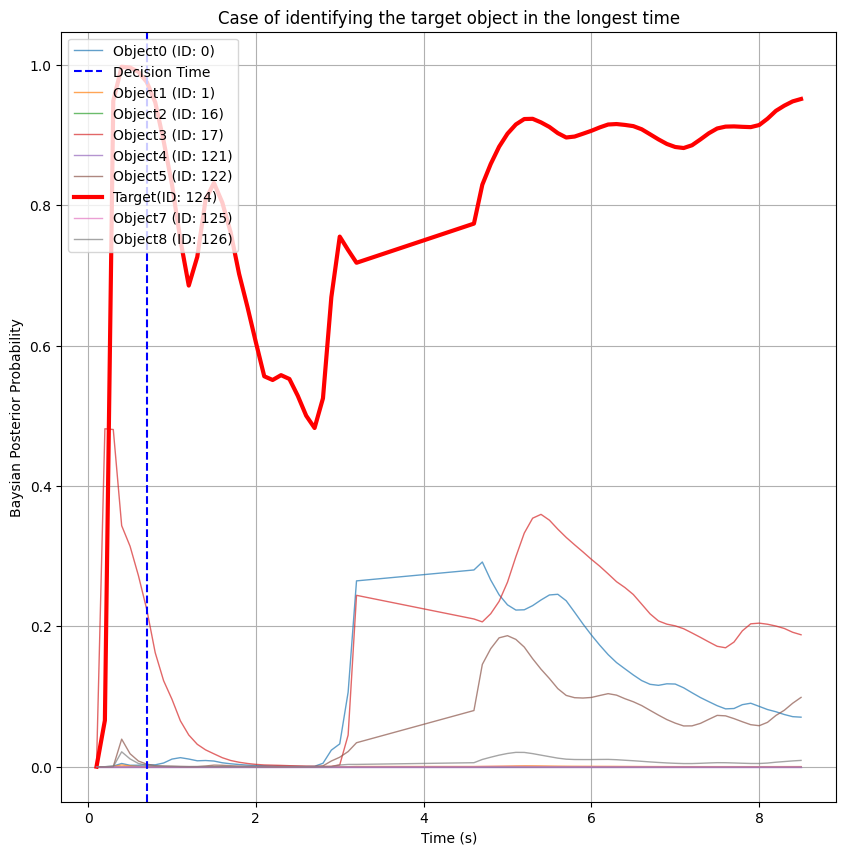

box0_data2.csv
Total task time: 8.900019539
Decision time: 6.900017085
Success time rate: 0.7752811164923893
Original Order: ['Target(ID: 0)', 'Object1 (ID: 1)', 'Object2 (ID: 16)', 'Object3 (ID: 17)', 'Object4 (ID: 121)', 'Object5 (ID: 122)', 'Object6 (ID: 124)', 'Object7 (ID: 125)', 'Object8 (ID: 126)', 'Decision Time']


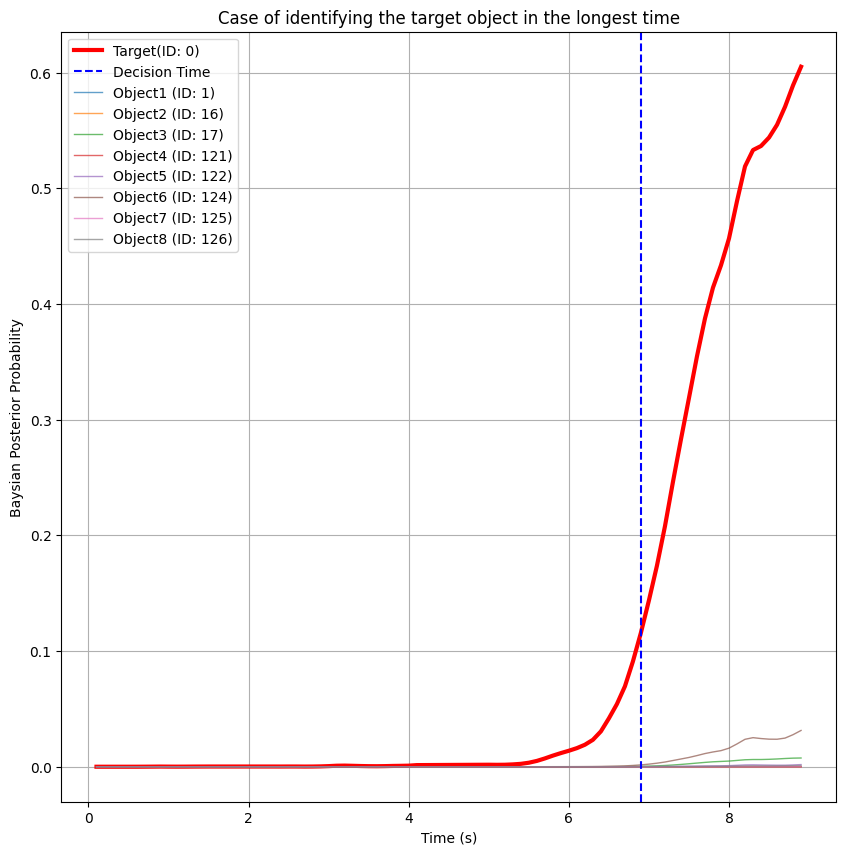

In [56]:
root_dir = "/home/workspace/src/log_file/pose_processed(3)"

file_names = sorted(os.listdir(root_dir))

file_names = ["box124_data2.csv", "box0_data2.csv"]

final_results = []


for file_name in file_names:
    full_file_name = os.path.join(root_dir, file_name)

    data = pd.read_csv(full_file_name)

    # 소수점 3자리까지 반올림
    bayesian_threshold = 0.1
    bayesian_diff_threshold = 0.1
    intersection_length_threshold = 9

    # 박스의 id 컬럼
    box_id_cols = [f"field.boxes{idx}.id" for idx in range(9)]

    # 베이지안 컬럼
    baysian_cols = [f"baysian{idx}" for idx in range(9)]

    # 모두 NaN인 행 제거
    cols = box_id_cols + baysian_cols
    data = data.dropna(subset=cols)

    target_id = int(data["desired_box"].iloc[0])

    # 임계점 설정

    # 1. 베이지안 값이 threshold 이상인 경우
    # 2. 1st 베이지안 값과 2nd 베이지안 값의 차이가 diff 이상인 경우

    # 가장 큰 값과 두 번째로 큰 값 찾기

    # 베이지안 데이터만 추출
    baysian_columns = [f"baysian{i}" for i in range(9)]
    baysian_data = data[baysian_columns]

    # 최대값과 두 번째로 큰 값 찾기
    # 가장 큰 베이지안 값의 컬럼 식별
    first_baysian = baysian_data.max(axis=1)
    second_baysian = baysian_data.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
    intersection_length = data["intersection_length"]

    # 임계점 조건을 동시에 만족하는 데이터프레임 생성
    data["decision"] = (
        (first_baysian >= bayesian_threshold)
        & (first_baysian - second_baysian >= bayesian_diff_threshold)
        & (intersection_length >= intersection_length_threshold)
    )

    # 가장 큰 베이지안 값의 컬럼 식별
    max_baysian_columns = baysian_data.idxmax(axis=1)
    max_baysian_columns = max_baysian_columns.apply(lambda x: f"field.boxes{x[-1]}.id")

    # 가장 큰 베이지안 값의 박스 id를 결정 id로 설정
    data["decision_id"] = data.apply(
        lambda row: row[max_baysian_columns[row.name]], axis=1
    )
    data["decision_id"] = data["decision_id"].astype(int)

    # 1. 정확하게 판단했는지 여부
    # 2. 판단한 시간

    # 첫 번째로 True인 인덱스 찾기. 없는 경우 마지막 인덱스로 설정
    if data["decision"].any():
        first_true_index = data["decision"].idxmax()
    else:
        first_true_index = len(data) - 1

    try:

        decision_time = data["%time"].loc[first_true_index]
        total_task_time = data["%time"].iloc[-1]
        success_time_rate = decision_time / total_task_time

        is_success = data["decision_id"].loc[first_true_index] == target_id

    except Exception as e:
        decision_time = np.nan
        success_time_rate = np.nan
        is_success = False

    print(file_name)
    print(f"Total task time: {total_task_time}")
    print(f"Decision time: {decision_time}")
    print(f"Success time rate: {success_time_rate}")

    result = {
        "file_name": file_name,
        "bayesian_threshold": bayesian_threshold,
        "bayesian_diff_threshold": bayesian_diff_threshold,
        "intersection_length_threshold": intersection_length_threshold,
        "success_time_rate": success_time_rate,
        "is_success": is_success,
    }

    final_results.append(result)

    plot = True

    if plot:
        # 각 박스의 베이지안 그래프 그리기
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for i in range(len(desired_box_values)):
            box_id = int(data[f"field.boxes{i}.id"].iloc[0])
            plt.plot(
                data["%time"].to_numpy(),
                data[f"baysian{i}"].to_numpy(),
                label=(
                    f"Target(ID: {box_id})"
                    if box_id == target_id
                    else f"Object{i} (ID: {box_id})"
                ),
                c="r" if box_id == target_id else None,
                linewidth=3 if box_id == target_id else 1,
                alpha=1.0 if box_id == target_id else 0.7,
            )

        # 판단 시간 표시
        plt.axvline(
            x=decision_time,
            color="blue" if is_success else "red",
            linestyle="--",
            label="Decision Time",
        )

        # 기존 순서 확인
        handles, labels = plt.gca().get_legend_handles_labels()
        print("Original Order:", labels)

        # 원하는 순서로 정렬
        order = [0, 9, 1, 2, 3, 4, 5, 6, 7, 8]  # Tangent -> Sine -> Cosine
        handles = [handles[i] for i in order]
        labels = [labels[i] for i in order]

        # 범례 그리기
        plt.legend(handles, labels, loc="upper left")
        # plt.legend()

        plt.grid()

        # plt.xlim(-0.1, 10.0)
        # plt.ylim(-0.1, 1.1)

        plt.xlabel("Time (s)")
        plt.ylabel("Baysian Posterior Probability")

        plt.title(f"Case of identifying the target object in the longest time")
        # "Case of identifying the target object in the shortest time"
        # "Case of identifying the target object in the longest time""

        plt.show()

    # break

export = False

if export:

    final_results_df = pd.DataFrame(final_results)
    final_results_df.to_csv(
        "/home/workspace/src/log_file/final_results_1.csv",
        index=False,
        encoding="utf-8",
    )

,bayesian_threshold,bayesian_diff_threshold,intersection_length_threshold,average_success_time_rate,max_success_time_rate,min_success_time_rate,average_success_rate,normalized_success_rate,normalized_success_time_rate,score
8,0.1,0.1,9,0.342584,0.775281,0.082350,1.0,1.0,0.893540,0.968062
9,0.1,0.1,10,0.344890,0.775281,0.088895,1.0,1.0,0.887775,0.966333
10,0.1,0.1,11,0.354904,0.775281,0.100002,1.0,1.0,0.862741,0.958822
11,0.1,0.1,12,0.358256,0.775281,0.111114,1.0,1.0,0.854360,0.956308
12,0.1,0.1,13,0.362713,0.775281,0.114616,1.0,1.0,0.843217,0.952965


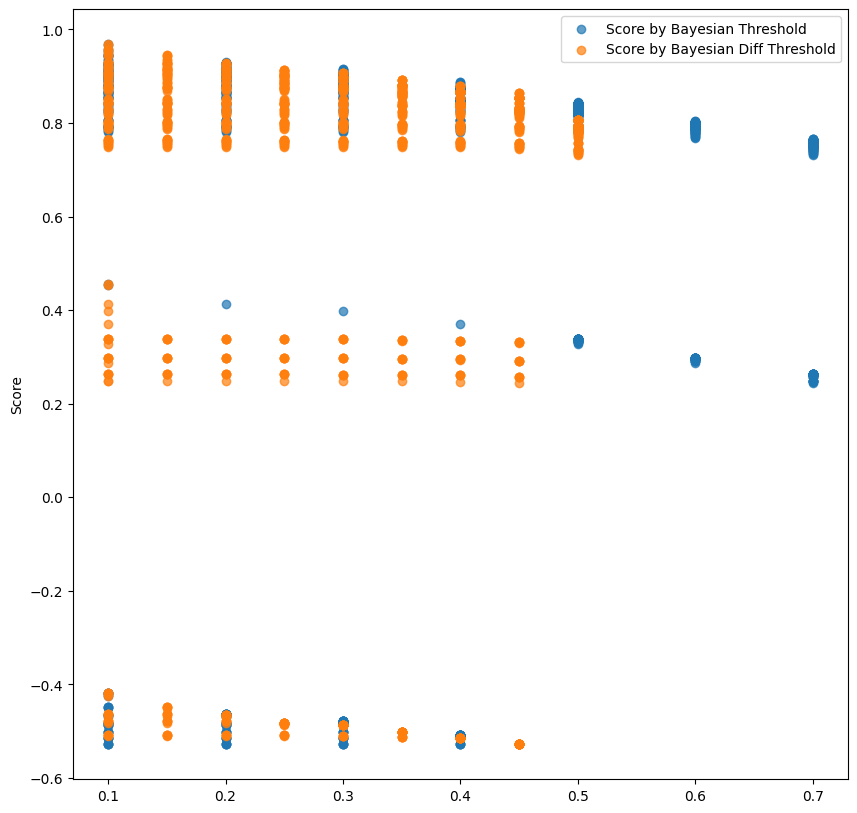

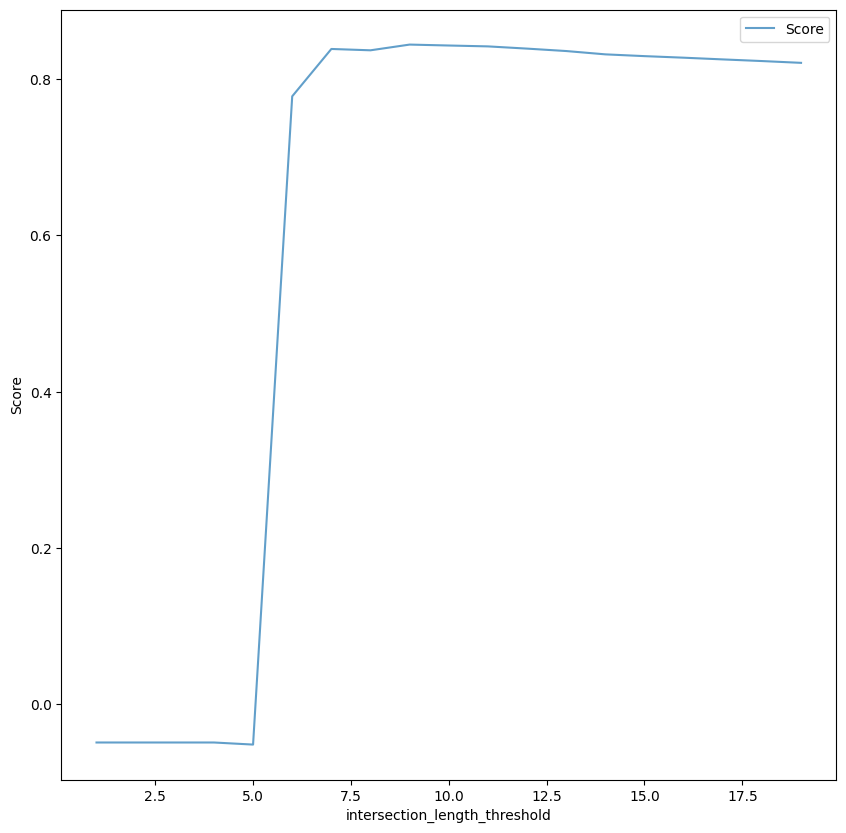

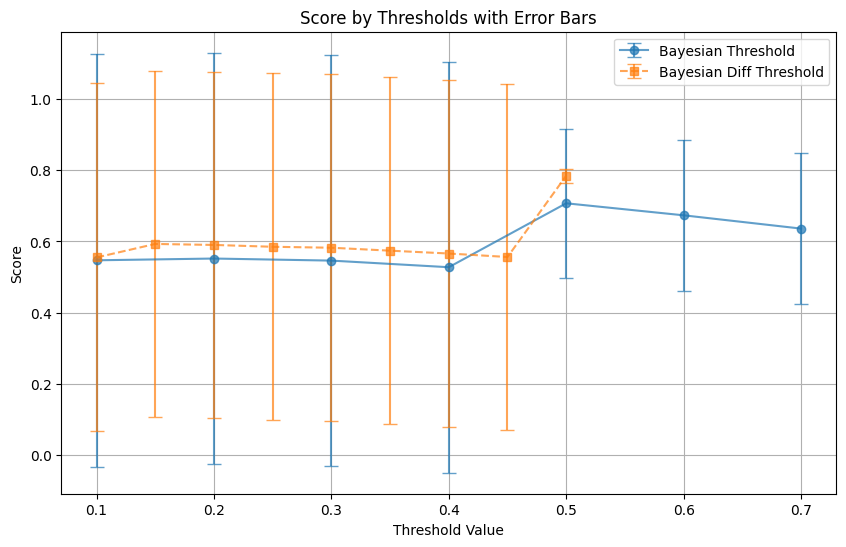

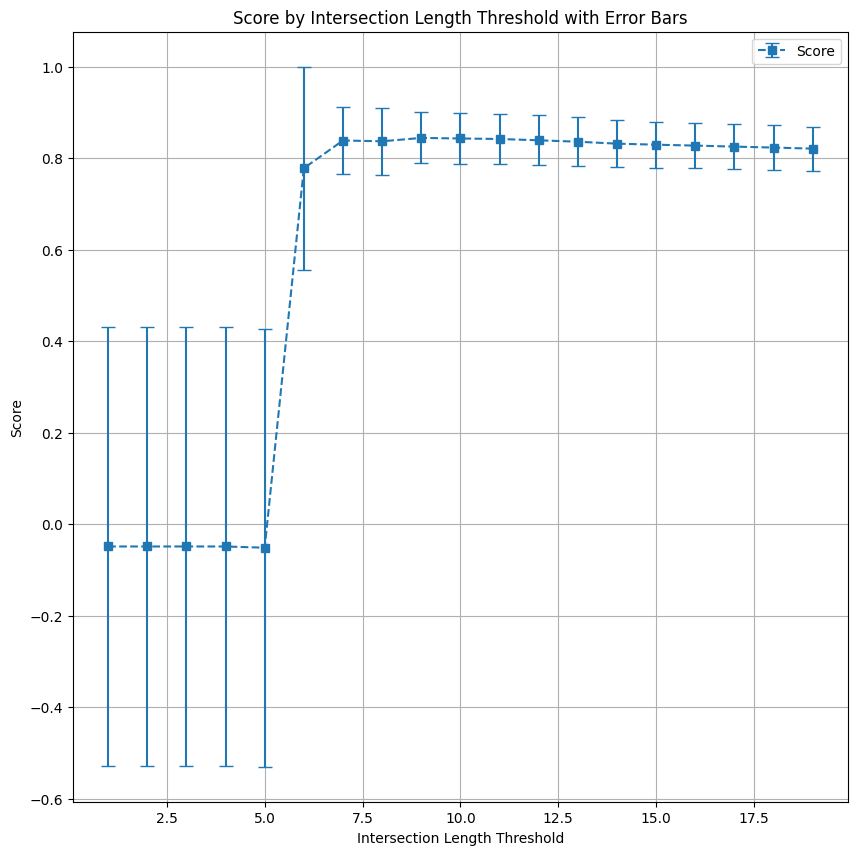

In [32]:
data = pd.read_csv("/home/workspace/src/log_file/final_results_by_params_2.csv")
data["intersection_length_threshold"] = data["intersection_length_threshold"].astype(
    int
)

# data = data[data["intersection_length_threshold"] >= 9]

bayesian_threshold_list = data["bayesian_threshold"].unique().tolist()
bayesian_diff_threshold_list = data["bayesian_diff_threshold"].unique().tolist()
intersection_length_threshold_list = (
    data["intersection_length_threshold"].unique().tolist()
)

success_rate = data["average_success_rate"]
success_time_rate = data["average_success_time_rate"]


# 1. success_rate 정규화
def normalize_success_rate(rate):
    if rate >= 1.0:
        return 1.0
    elif rate >= 0.95:
        return (rate - 0.95) / (1.0 - 0.95)  # 0.95~1.0 정규화
    else:
        return (rate - 0.95) / (0.95 - rate)  # 0.95보다 작으면 음수


data["normalized_success_rate"] = data["average_success_rate"].apply(
    normalize_success_rate
)

# 2. success_time_rate 정규화
data["normalized_success_time_rate"] = (0.7 - data["average_success_time_rate"]) / (
    0.7 - 0.3
)

# 3. 정규화된 값을 가중합 계산
data["score"] = (
    0.7 * data["normalized_success_rate"] + 0.3 * data["normalized_success_time_rate"]
)

"""
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bayesian_threshold             231 non-null    float64
 1   bayesian_diff_threshold        231 non-null    float64
 2   intersection_length_threshold  231 non-null    float64
 3   average_success_time_rate      231 non-null    float64
 4   max_success_time_rate          231 non-null    float64
 5   min_success_time_rate          231 non-null    float64
 6   average_success_rate           231 non-null    float64
 """

if False:

    # bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
    grouped_data_by_bayesian_threshold = data.groupby(
        "bayesian_threshold", as_index=False
    ).mean()

    # X - bayesian_threshold
    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_bayesian_threshold["bayesian_threshold"],
        grouped_data_by_bayesian_threshold["average_success_time_rate"],
        alpha=0.7,
        label="Average Success Time Rate",
    )
    plt.plot(
        grouped_data_by_bayesian_threshold["bayesian_threshold"],
        grouped_data_by_bayesian_threshold["max_success_time_rate"],
        alpha=0.7,
        label="Max Success Time Rate",
    )
    plt.plot(
        grouped_data_by_bayesian_threshold["bayesian_threshold"],
        grouped_data_by_bayesian_threshold["min_success_time_rate"],
        alpha=0.7,
        label="Min Success Time Rate",
    )
    plt.xlabel("Bayesian Threshold")
    plt.ylabel("Success Time Rate")
    plt.title("Success Time Rate by Bayesian Threshold")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_bayesian_threshold["bayesian_threshold"],
        grouped_data_by_bayesian_threshold["average_success_rate"],
        alpha=0.7,
        label="Average Success Rate",
    )
    plt.xlabel("Bayesian Threshold")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate by Bayesian Threshold")
    plt.legend()
    plt.show()

    # bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
    grouped_data_by_bayesian_diff_threshold = data.groupby(
        "bayesian_diff_threshold", as_index=False
    ).mean()

    # X - bayesian_diff_threshold
    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_bayesian_diff_threshold["bayesian_diff_threshold"],
        grouped_data_by_bayesian_diff_threshold["average_success_time_rate"],
        alpha=0.7,
        label="Average Success Time Rate",
    )
    plt.plot(
        grouped_data_by_bayesian_diff_threshold["bayesian_diff_threshold"],
        grouped_data_by_bayesian_diff_threshold["max_success_time_rate"],
        alpha=0.7,
        label="Max Success Time Rate",
    )
    plt.plot(
        grouped_data_by_bayesian_diff_threshold["bayesian_diff_threshold"],
        grouped_data_by_bayesian_diff_threshold["min_success_time_rate"],
        alpha=0.7,
        label="Min Success Time Rate",
    )
    plt.xlabel("Bayesian Diff Threshold")
    plt.ylabel("Success Time Rate")
    plt.title("Success Time Rate by Bayesian Diff Threshold")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_bayesian_diff_threshold["bayesian_diff_threshold"],
        grouped_data_by_bayesian_diff_threshold["average_success_rate"],
        alpha=0.7,
        label="Average Success Rate",
    )
    plt.xlabel("Bayesian Diff Threshold")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate by Bayesian Diff Threshold")
    plt.legend()
    plt.show()

    # bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
    grouped_data_by_intersection_length_threshold = data.groupby(
        "intersection_length_threshold", as_index=False
    ).mean()

    # X - intersection_length_threshold
    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_intersection_length_threshold["intersection_length_threshold"],
        grouped_data_by_intersection_length_threshold["average_success_time_rate"],
        alpha=0.7,
        label="Average Success Time Rate",
    )
    plt.plot(
        grouped_data_by_intersection_length_threshold["intersection_length_threshold"],
        grouped_data_by_intersection_length_threshold["max_success_time_rate"],
        alpha=0.7,
        label="Max Success Time Rate",
    )
    plt.plot(
        grouped_data_by_intersection_length_threshold["intersection_length_threshold"],
        grouped_data_by_intersection_length_threshold["min_success_time_rate"],
        alpha=0.7,
        label="Min Success Time Rate",
    )
    plt.xlabel("Number of Intersection Length Threshold")
    plt.ylabel("Success Time Rate")
    plt.title("Success Time Rate by Number of Intersection Length")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(
        grouped_data_by_intersection_length_threshold["intersection_length_threshold"],
        grouped_data_by_intersection_length_threshold["average_success_rate"],
        alpha=0.7,
        label="Average Success Rate",
    )
    plt.xlabel("Number of Intersection Length Threshold")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate by Number of Intersection Length")
    plt.legend()
    plt.show()


data = data.sort_values(by="score", ascending=False)

display(data.head())


# bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
grouped_data_by_bayesian_threshold = data.groupby(
    "bayesian_threshold", as_index=False
).mean()

# bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
grouped_data_by_bayesian_diff_threshold = data.groupby(
    "bayesian_diff_threshold", as_index=False
).mean()

# bayesian_threshold에 따른 average_success_time_rate의 평균값 계산
grouped_data_by_intersection_length_threshold = data.groupby(
    "intersection_length_threshold", as_index=False
).mean()

plt.figure(figsize=(10, 10))
plt.scatter(
    data["bayesian_threshold"],
    data["score"],
    alpha=0.7,
    label="Score by Bayesian Threshold",
)
plt.scatter(
    data["bayesian_diff_threshold"],
    data["score"],
    alpha=0.7,
    label="Score by Bayesian Diff Threshold",
)
plt.ylabel("Score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(
    grouped_data_by_intersection_length_threshold["intersection_length_threshold"],
    grouped_data_by_intersection_length_threshold["score"],
    alpha=0.7,
    label="Score",
)
plt.xlabel("intersection_length_threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


# 1. bayesian_threshold에 따른 평균과 표준편차 계산
threshold_stats = (
    data.groupby("bayesian_threshold")["score"].agg(["mean", "std"]).reset_index()
)
diff_stats = (
    data.groupby("bayesian_diff_threshold")["score"].agg(["mean", "std"]).reset_index()
)
length_stats = (
    data.groupby("intersection_length_threshold")["score"]
    .agg(["mean", "std"])
    .reset_index()
)

# 2. 에러바 그래프 그리기
plt.figure(figsize=(10, 6))

# Bayesian Threshold
plt.errorbar(
    threshold_stats["bayesian_threshold"],  # X축
    threshold_stats["mean"],  # Y축 평균값
    yerr=threshold_stats["std"],  # 표준편차
    fmt="o-",  # 선 스타일과 마커
    label="Bayesian Threshold",
    capsize=5,  # 에러바 끝 모양 크기
    alpha=0.7,
)

# Bayesian Diff Threshold
plt.errorbar(
    diff_stats["bayesian_diff_threshold"],
    diff_stats["mean"],
    yerr=diff_stats["std"],
    fmt="s--",  # 선 스타일과 마커
    label="Bayesian Diff Threshold",
    capsize=5,
    alpha=0.7,
)

# 그래프 꾸미기
plt.title("Score by Thresholds with Error Bars")
plt.xlabel("Threshold Value")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 10))

# Bayesian Diff Threshold
plt.errorbar(
    length_stats["intersection_length_threshold"],
    length_stats["mean"],
    yerr=length_stats["std"],
    fmt="s--",  # 선 스타일과 마커
    label="Score",
    capsize=5,
    alpha=1.0,
)

# 그래프 꾸미기
plt.title("Score by Intersection Length Threshold with Error Bars")
plt.xlabel("Intersection Length Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
root_dir = "/home/workspace/src/log_file/pose_processed(3)"

file_names = sorted(os.listdir(root_dir))


final_results = []


for file_name in file_names:
    full_file_name = os.path.join(root_dir, file_name)

    bayesian_threshold = 0.1
    bayesian_diff_threshold = 0.1
    intersection_length_threshold = 10

    data = pd.read_csv(full_file_name)

    # 소수점 3자리까지 반올림
    bayesian_threshold = round(bayesian_threshold, 3)
    bayesian_diff_threshold = round(bayesian_diff_threshold, 3)

    # 박스의 id 컬럼
    box_id_cols = [f"field.boxes{idx}.id" for idx in range(9)]

    # 베이지안 컬럼
    baysian_cols = [f"baysian{idx}" for idx in range(9)]

    # 모두 NaN인 행 제거
    cols = box_id_cols + baysian_cols
    data = data.dropna(subset=cols)

    target_id = int(data["desired_box"].iloc[0])

    # 임계점 설정

    # 1. 베이지안 값이 threshold 이상인 경우
    # 2. 1st 베이지안 값과 2nd 베이지안 값의 차이가 diff 이상인 경우

    # 가장 큰 값과 두 번째로 큰 값 찾기

    # 베이지안 데이터만 추출
    baysian_columns = [f"baysian{i}" for i in range(9)]
    baysian_data = data[baysian_columns]

    # 최대값과 두 번째로 큰 값 찾기
    # 가장 큰 베이지안 값의 컬럼 식별
    first_baysian = baysian_data.max(axis=1)
    second_baysian = baysian_data.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
    intersection_length = data["intersection_length"]

    # 임계점 조건을 동시에 만족하는 데이터프레임 생성
    data["decision"] = (
        (first_baysian >= bayesian_threshold)
        & (first_baysian - second_baysian >= bayesian_diff_threshold)
        & (intersection_length >= intersection_length_threshold)
    )

    # 가장 큰 베이지안 값의 컬럼 식별
    max_baysian_columns = baysian_data.idxmax(axis=1)
    max_baysian_columns = max_baysian_columns.apply(lambda x: f"field.boxes{x[-1]}.id")

    # 가장 큰 베이지안 값의 박스 id를 결정 id로 설정
    data["decision_id"] = data.apply(
        lambda row: row[max_baysian_columns[row.name]], axis=1
    )
    data["decision_id"] = data["decision_id"].astype(int)

    # 1. 정확하게 판단했는지 여부
    # 2. 판단한 시간

    # 첫 번째로 True인 인덱스 찾기. 없는 경우 마지막 인덱스로 설정
    if data["decision"].any():
        first_true_index = data["decision"].idxmax()
    else:
        first_true_index = len(data) - 1

    try:

        decision_time = data["%time"].loc[first_true_index]
        success_time_rate = decision_time / data["%time"].iloc[-1]

        is_success = data["decision_id"].loc[first_true_index] == target_id

    except Exception as e:
        decision_time = np.nan
        success_time_rate = np.nan
        is_success = False

    result = {
        "file_name": file_name,
        "bayesian_threshold": bayesian_threshold,
        "bayesian_diff_threshold": bayesian_diff_threshold,
        "intersection_length_threshold": intersection_length_threshold,
        "success_time_rate": success_time_rate,
        "is_success": is_success,
    }

    print(result)

    final_results.append(result)

df = pd.DataFrame(final_results)
display(df)

{'file_name': 'box0_data0.csv', 'bayesian_threshold': 0.1, 'bayesian_diff_threshold': 0.1, 'intersection_length_threshold': 10, 'success_time_rate': 0.09278425851522062, 'is_success': True}
{'file_name': 'box0_data1.csv', 'bayesian_threshold': 0.1, 'bayesian_diff_threshold': 0.1, 'intersection_length_threshold': 10, 'success_time_rate': 0.09890562801168737, 'is_success': True}
{'file_name': 'box0_data2.csv', 'bayesian_threshold': 0.1, 'bayesian_diff_threshold': 0.1, 'intersection_length_threshold': 10, 'success_time_rate': 0.7752811164923893, 'is_success': True}
{'file_name': 'box121_data0.csv', 'bayesian_threshold': 0.1, 'bayesian_diff_threshold': 0.1, 'intersection_length_threshold': 10, 'success_time_rate': 0.6666675926283697, 'is_success': True}
{'file_name': 'box121_data1.csv', 'bayesian_threshold': 0.1, 'bayesian_diff_threshold': 0.1, 'intersection_length_threshold': 10, 'success_time_rate': 0.22535051397106198, 'is_success': True}
{'file_name': 'box121_data2.csv', 'bayesian_thre

,file_name,bayesian_threshold,bayesian_diff_threshold,intersection_length_threshold,success_time_rate,is_success
0,box0_data0.csv,0.1,0.1,10,0.092784,True
1,box0_data1.csv,0.1,0.1,10,0.098906,True
2,box0_data2.csv,0.1,0.1,10,0.775281,True
3,box121_data0.csv,0.1,0.1,10,0.666668,True
4,box121_data1.csv,0.1,0.1,10,0.225351,True
5,box121_data2.csv,0.1,0.1,10,0.200000,True
6,box122_data0.csv,0.1,0.1,10,0.088895,True
7,box122_data1.csv,0.1,0.1,10,0.704552,True
8,box122_data2.csv,0.1,0.1,10,0.688892,True
9,box124_data0.csv,0.1,0.1,10,0.114616,True
